In [1]:
import nltk
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics 
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import re
import random
from sklearn.linear_model import LogisticRegression

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/fatma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " ", string)
    string = re.sub(r"\'ve", " ", string)
    string = re.sub(r"n\'t", " ", string)
    string = re.sub(r"n\'s", " ", string)
    string = re.sub(r"\'re", " ", string)
    string = re.sub(r"\'d", " ", string)
    string = re.sub(r"\'ll", " ", string)
    string = re.sub(r",", " ", string)
    string = re.sub(r"!", " ", string)
    string = re.sub(r"\(", " ", string)
    string = re.sub(r"\)", " ", string)
    string = re.sub(r"\?", " ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\//?", " ", string)
    string = re.sub(r"\d+", " ", string)
    string = re.sub(r"\$", " ", string)
    string = re.sub(r"\#", " ", string)
    return string.strip().lower()

In [83]:
def remove_stop(str):
    stop = set(stopwords.words('english'))
    lst = str.split()
    lst = [i for i in lst if i not in stop]
    return ' '.join(lst)

def stem (str):
    lst = str.split()
    lst = [st.stem(x) for x in lst]
    return ' '.join(lst)

def remove_unwanted_words(str):
    unwanted_words = ["httpaddress", "usrid", "D", "dd", "rt", "amp", "am", "pm", '``',
                      "''", "", "//", "\\", "\\'s", "\\?", "\?","http","httpaddresshttpaddresst", "cohttpaddressek",
                      "taksim","gezi", "park", "direngeziparki", "occupygezi", "istanbul", "turkish","turkey",
                      "protest","direngezipark","direnankara","geziparki", "protesters", "protests", "sat", "sun", "mon,",
                     "tue", "wed", "thu", "fri", "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
    lst = str.split(" ")
    lst = [i for i in lst if i not in unwanted_words]
    return ' '.join(lst)

def toLower(str):
    lst = str.split()
    lst = [i.lower() for i in lst]
    return ' '.join(lst)

def word_len (str):
    lst = str.split()
    lst = [i for i in lst if len(i)>1 and len(i) <7]
    return ' '.join(lst)

def sent_len (str):
    lst = str.split()
    if len(lst)>=3:
        return ' '.join(lst)

In [84]:
def clean_data(data):
    """
    Loads MR polarity african_data from files, splits the african_data into words and generates labels.
    Returns split sentences and labels.
    """
    # Load african_data from files
    positive_examples = data
    positive_examples = positive_examples.strip() 
    positive_examples = remove_stop(positive_examples) 
    #print(positive_examples[0])
    positive_examples = toLower(positive_examples) 
    #rint(positive_examples[0])
    positive_examples = clean_str(positive_examples) 
    #rint(positive_examples[0])
    #positive_examples = [stem(item) for item in positive_examples]
    #rint(positive_examples[0])
    positive_examples = remove_unwanted_words(positive_examples)
    #positive_examples = word_len(positive_examples) 
    #positive_examples = sent_len(positive_examples) 
    
    return positive_examples
    

In [126]:
df_cf_judgments = pd.read_csv('Data/CF_confidence_judgments_finalized.csv')

In [127]:
df_cf_judgments.columns

Index(['_unit_id', 'text_x', 'text_y', 'proccd_text_x', 'protest_x',
       'protest_y', 'protest_confidence', 'violence_x', 'violence_y',
       'violence_confidence', 'created_at_x', '_golden_x'],
      dtype='object')

In [128]:
df_cf_judgments.rename(columns={'violence_y':'violence'},inplace=True)

In [129]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['_golden_x']==False]

In [130]:
len(df_cf_judgments)

1315

In [131]:
len(df_cf_judgments.drop_duplicates())

1315

In [132]:
df_cf_judgments

,_unit_id,text_x,text_y,proccd_text_x,protest_x,protest_y,protest_confidence,violence_x,violence,violence_confidence,created_at_x,_golden_x
0,1657977939,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,lawn goose clothes lot DD outfit pattern sewin...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Sat Jun 15 12:14:33 +0000 2013,False
1,1657977940,RT @VOT99: Turkish Police have blacked out ID ...,RT @VOT99: Turkish Police have blacked out ID ...,rt usrId turkish police have blacked out id nu...,1\r1\r1,1,1.0000,0\r1\r0,0.0,0.6606,Tue Jun 04 16:04:35 +0000 2013,False
2,1657977941,RT @CihanSCelik: #Occupy #Taksim protesters in...,RT @CihanSCelik: #Occupy #Taksim protesters in...,rt usrId #occupy #taksim protesters in #istanb...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Sat Jun 01 07:12:41 +0000 2013,False
3,1657977942,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,rt usrId usrId erdogan says vandals entering m...,0\r1\r0,0,0.6767,\r1\r,1.0,1.0000,Sun Jun 09 14:53:50 +0000 2013,False
4,1657977943,"Photoset: forest-dreams: Turkey needs support,...","Photoset: forest-dreams: Turkey needs support,...",photoset forest dreams turkey needs support as...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Sat Jun 01 22:08:17 +0000 2013,False
5,1657977944,RT @wsjemre: Protesters set up barricades to h...,RT @wsjemre: Protesters set up barricades to h...,rt usrId protesters set up barricades to halt ...,1\r1\r0,1,0.6590,0\r0\r,0.0,1.0000,Sat Jun 01 19:58:31 +0000 2013,False
6,1657977945,RT @AlganSez: police. fascism. turkey. now. ht...,RT @AlganSez: police. fascism. turkey. now. ht...,rt usrId httpAddress httpAddress httpAddress h...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Mon Jun 03 22:57:24 +0000 2013,False
7,1657977946,RT @anafoulla: Moroccans protesting Erdogan's ...,RT @anafoulla: Moroccans protesting Erdogan's ...,rt usrId moroccans protesting erdogan s visit ...,1\r0\r1,1,0.6515,0\r\r0,0.0,1.0000,Mon Jun 03 19:19:02 +0000 2013,False
8,1657977947,Taksim Square and Gezi Park Protests: Designin...,Taksim Square and Gezi Park Protests: Designin...,taksim square and gezi park protests designing...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Thu Jun 13 13:27:20 +0000 2013,False
9,1657977948,RT @dowjones_yeliz: Investors baffled by Turke...,RT @dowjones_yeliz: Investors baffled by Turke...,rt usrId investors baffled by turkey protests ...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Wed Jun 05 17:39:21 +0000 2013,False


In [133]:
df_cf_judgments = df_cf_judgments[df_cf_judgments['violence']!=-1]

In [134]:
df_cf_judgments

,_unit_id,text_x,text_y,proccd_text_x,protest_x,protest_y,protest_confidence,violence_x,violence,violence_confidence,created_at_x,_golden_x
0,1657977939,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,lawn goose clothes lot DD outfit pattern sewin...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Sat Jun 15 12:14:33 +0000 2013,False
1,1657977940,RT @VOT99: Turkish Police have blacked out ID ...,RT @VOT99: Turkish Police have blacked out ID ...,rt usrId turkish police have blacked out id nu...,1\r1\r1,1,1.0000,0\r1\r0,0.0,0.6606,Tue Jun 04 16:04:35 +0000 2013,False
2,1657977941,RT @CihanSCelik: #Occupy #Taksim protesters in...,RT @CihanSCelik: #Occupy #Taksim protesters in...,rt usrId #occupy #taksim protesters in #istanb...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Sat Jun 01 07:12:41 +0000 2013,False
3,1657977942,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,rt usrId usrId erdogan says vandals entering m...,0\r1\r0,0,0.6767,\r1\r,1.0,1.0000,Sun Jun 09 14:53:50 +0000 2013,False
4,1657977943,"Photoset: forest-dreams: Turkey needs support,...","Photoset: forest-dreams: Turkey needs support,...",photoset forest dreams turkey needs support as...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Sat Jun 01 22:08:17 +0000 2013,False
5,1657977944,RT @wsjemre: Protesters set up barricades to h...,RT @wsjemre: Protesters set up barricades to h...,rt usrId protesters set up barricades to halt ...,1\r1\r0,1,0.6590,0\r0\r,0.0,1.0000,Sat Jun 01 19:58:31 +0000 2013,False
6,1657977945,RT @AlganSez: police. fascism. turkey. now. ht...,RT @AlganSez: police. fascism. turkey. now. ht...,rt usrId httpAddress httpAddress httpAddress h...,0\r0\r0,0,1.0000,\r\r,NaN,NaN,Mon Jun 03 22:57:24 +0000 2013,False
7,1657977946,RT @anafoulla: Moroccans protesting Erdogan's ...,RT @anafoulla: Moroccans protesting Erdogan's ...,rt usrId moroccans protesting erdogan s visit ...,1\r0\r1,1,0.6515,0\r\r0,0.0,1.0000,Mon Jun 03 19:19:02 +0000 2013,False
8,1657977947,Taksim Square and Gezi Park Protests: Designin...,Taksim Square and Gezi Park Protests: Designin...,taksim square and gezi park protests designing...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Thu Jun 13 13:27:20 +0000 2013,False
9,1657977948,RT @dowjones_yeliz: Investors baffled by Turke...,RT @dowjones_yeliz: Investors baffled by Turke...,rt usrId investors baffled by turkey protests ...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Wed Jun 05 17:39:21 +0000 2013,False


In [135]:
df_cf_judgments['violence'] = df_cf_judgments['violence'].fillna(0)

In [136]:
df_cf_judgments

,_unit_id,text_x,text_y,proccd_text_x,protest_x,protest_y,protest_confidence,violence_x,violence,violence_confidence,created_at_x,_golden_x
0,1657977939,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,lawn goose clothes lot DD outfit pattern sewin...,0\r0\r0,0,1.0000,\r\r,0.0,NaN,Sat Jun 15 12:14:33 +0000 2013,False
1,1657977940,RT @VOT99: Turkish Police have blacked out ID ...,RT @VOT99: Turkish Police have blacked out ID ...,rt usrId turkish police have blacked out id nu...,1\r1\r1,1,1.0000,0\r1\r0,0.0,0.6606,Tue Jun 04 16:04:35 +0000 2013,False
2,1657977941,RT @CihanSCelik: #Occupy #Taksim protesters in...,RT @CihanSCelik: #Occupy #Taksim protesters in...,rt usrId #occupy #taksim protesters in #istanb...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Sat Jun 01 07:12:41 +0000 2013,False
3,1657977942,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,RT @MarietjeSchaake: @MarkABentley: Erdogan sa...,rt usrId usrId erdogan says vandals entering m...,0\r1\r0,0,0.6767,\r1\r,1.0,1.0000,Sun Jun 09 14:53:50 +0000 2013,False
4,1657977943,"Photoset: forest-dreams: Turkey needs support,...","Photoset: forest-dreams: Turkey needs support,...",photoset forest dreams turkey needs support as...,0\r0\r0,0,1.0000,\r\r,0.0,NaN,Sat Jun 01 22:08:17 +0000 2013,False
5,1657977944,RT @wsjemre: Protesters set up barricades to h...,RT @wsjemre: Protesters set up barricades to h...,rt usrId protesters set up barricades to halt ...,1\r1\r0,1,0.6590,0\r0\r,0.0,1.0000,Sat Jun 01 19:58:31 +0000 2013,False
6,1657977945,RT @AlganSez: police. fascism. turkey. now. ht...,RT @AlganSez: police. fascism. turkey. now. ht...,rt usrId httpAddress httpAddress httpAddress h...,0\r0\r0,0,1.0000,\r\r,0.0,NaN,Mon Jun 03 22:57:24 +0000 2013,False
7,1657977946,RT @anafoulla: Moroccans protesting Erdogan's ...,RT @anafoulla: Moroccans protesting Erdogan's ...,rt usrId moroccans protesting erdogan s visit ...,1\r0\r1,1,0.6515,0\r\r0,0.0,1.0000,Mon Jun 03 19:19:02 +0000 2013,False
8,1657977947,Taksim Square and Gezi Park Protests: Designin...,Taksim Square and Gezi Park Protests: Designin...,taksim square and gezi park protests designing...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Thu Jun 13 13:27:20 +0000 2013,False
9,1657977948,RT @dowjones_yeliz: Investors baffled by Turke...,RT @dowjones_yeliz: Investors baffled by Turke...,rt usrId investors baffled by turkey protests ...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Wed Jun 05 17:39:21 +0000 2013,False


In [137]:
df_cf_judgments['clean_text'] = df_cf_judgments['text_x'].apply(lambda x:clean_data(x) )

In [115]:
df_cf_judgments.columns

Index(['_unit_id', 'text_x', 'text_y', 'proccd_text_x', 'protest_x',
       'protest_y', 'protest_confidence', 'violence_x', 'violence',
       'violence_confidence', 'created_at_x', '_golden_x', 'clean_text'],
      dtype='object')

In [116]:
test_predict_auc_all =[]
svm_labels = []

for i in range(1,10):
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_cf_judgments.clean_text, 
                                                    df_cf_judgments.violence, 
                                                    test_size=0.5)
    df_train_df = pd.concat([df_X_train,df_y_train],axis=1)
    df_test_df = pd.concat([df_X_test,df_y_test],axis = 1)
    print('training set size', len(df_train_df))
    print('training pos', len(df_train_df[df_train_df["violence"]==1]))
    print('training neg', len(df_train_df[df_train_df["violence"]==0]))
    print('test set size', len(df_test_df))
    print('test pos', len(df_test_df[df_test_df["violence"]==1]))
    print('test neg', len(df_test_df[df_test_df["violence"]==0]))
    
    df_pipeline_violence_Svc = Pipeline([
    ('vectorizer',  CountVectorizer(ngram_range=(1, 2),stop_words='english',  min_df=3)),
    ('classifier',  SVC(kernel='linear', probability=True)) ])

    
    df_scores = cross_val_score(df_pipeline_violence_Svc, df_train_df.clean_text, df_train_df.violence, cv=10)
    print('scores',df_scores)
    print('scores mean',df_scores.mean())
    print('scores std',df_scores.std() * 2)
    
    df_cv_predict = cross_val_predict(df_pipeline_violence_Svc, df_train_df.clean_text, df_train_df.violence, cv=10)
    df_cv_predict_scores = metrics.roc_auc_score(df_train_df.violence, df_cv_predict)
    print('cv auc', df_cv_predict_scores)
    
    df_pipeline_violence_Svc_model = df_pipeline_violence_Svc.fit(df_train_df.clean_text, df_train_df.violence)
    df_prediction = df_pipeline_violence_Svc_model.predict(df_test_df.clean_text)
    df_predict_prob = df_pipeline_violence_Svc_model.predict_proba(df_test_df.clean_text)
    test_predict_auc = metrics.roc_auc_score(df_test_df.violence,df_prediction)
    print('test set auc', test_predict_auc)
    test_predict_auc_all.append(test_predict_auc)
    print(metrics.confusion_matrix(df_test_df.violence,df_prediction))

training set size 657
training pos 104
training neg 553
test set size 658
test pos 107
test neg 551
scores [0.89552239 0.88059701 0.94029851 0.86363636 0.87692308 0.92307692
 0.84615385 0.87692308 0.87692308 0.89230769]
scores mean 0.8872361966391817
scores std 0.05216289572450683
cv auc 0.7535296981499513
test set auc 0.6896806146852791
[[518  33]
 [ 60  47]]
training set size 657
training pos 97
training neg 560
test set size 658
test pos 114
test neg 544
scores [0.87878788 0.87878788 0.87878788 0.89393939 0.89393939 0.86363636
 0.84848485 0.83076923 0.92307692 0.89230769]
scores mean 0.8782517482517482
scores std 0.0492105674804699
cv auc 0.706958762886598
test set auc 0.7162022703818369
[[512  32]
 [ 58  56]]
training set size 657
training pos 93
training neg 564
test set size 658
test pos 118
test neg 540
scores [0.94029851 0.8358209  0.88059701 0.92424242 0.89230769 0.87692308
 0.90769231 0.81538462 0.84615385 0.89230769]
scores mean 0.8811728072922103
scores std 0.07465037718563

In [189]:
print('avg aucs on tests', np.mean(test_predict_auc_all))

avg aucs on tests 0.6948417258861057


In [138]:
svm_test_results_df = pd.DataFrame({'clean_text':df_test_df.clean_text,'violence_prediction':df_prediction,
                                    'non_vio_prob':df_predict_prob[:,0],'vio_prob':df_predict_prob[:,1]})

In [139]:
svm_test_results_df.to_csv('Data/svm_cf_task2_results.csv')

In [142]:
svm_results_CF_judgment_merged = df_cf_judgments.merge(svm_test_results_df,on='clean_text',how='right')

In [145]:
svm_results_CF_judgment_merged.to_csv('Data/svm_results_CF_judgment_merged.csv')

In [148]:
svm_results_CF_judgment_merged['violence_confidence'] = svm_results_CF_judgment_merged['violence_confidence'].fillna(0) 

In [188]:
svm_results_CF_judgment_merged

,_unit_id,text_x,text_y,proccd_text_x,protest_x,protest_y,protest_confidence,violence_x,violence,violence_confidence,created_at_x,_golden_x,clean_text,non_vio_prob,vio_prob,violence_prediction
0,1657977939,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,Lawn GOOSE Clothes Lot 15 Outfit Pattern Sewin...,lawn goose clothes lot DD outfit pattern sewin...,0\r0\r0,0,1.0000,\r\r,0.0,0.0000,Sat Jun 15 12:14:33 +0000 2013,False,lawn goose clothes lot outfit pattern sewing u...,0.928855,0.071145,0.0
1,1657977943,"Photoset: forest-dreams: Turkey needs support,...","Photoset: forest-dreams: Turkey needs support,...",photoset forest dreams turkey needs support as...,0\r0\r0,0,1.0000,\r\r,0.0,0.0000,Sat Jun 01 22:08:17 +0000 2013,False,photoset forest dreams needs support always me...,0.876506,0.123494,0.0
2,1657977945,RT @AlganSez: police. fascism. turkey. now. ht...,RT @AlganSez: police. fascism. turkey. now. ht...,rt usrId httpAddress httpAddress httpAddress h...,0\r0\r0,0,1.0000,\r\r,0.0,0.0000,Mon Jun 03 22:57:24 +0000 2013,False,algansez police fascism now t co s jrzut,0.812316,0.187684,0.0
3,1657977946,RT @anafoulla: Moroccans protesting Erdogan's ...,RT @anafoulla: Moroccans protesting Erdogan's ...,rt usrId moroccans protesting erdogan s visit ...,1\r0\r1,1,0.6515,0\r\r0,0.0,1.0000,Mon Jun 03 19:19:02 +0000 2013,False,anafoulla moroccans protesting erdogan visit i...,0.921057,0.078943,0.0
4,1657977948,RT @dowjones_yeliz: Investors baffled by Turke...,RT @dowjones_yeliz: Investors baffled by Turke...,rt usrId investors baffled by turkey protests ...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Wed Jun 05 17:39:21 +0000 2013,False,dowjones yeliz investors baffled moneybeat wsj...,0.734931,0.265069,0.0
5,1657977950,"Turkey police crush protests in Ankara, Istanb...","Turkey police crush protests in Ankara, Istanb...",turkey police crush protests in ankara istanbu...,1\r0\r1,1,0.6612,1\r\r1,1.0,1.0000,Mon Jun 10 03:49:59 +0000 2013,False,police crush ankara photos video,0.788275,0.211725,0.0
6,1657977954,RT @skyyfitsheaven: Police detaining protestor...,RT @skyyfitsheaven: Police detaining protestor...,rt usrId police detaining protestors in #diren...,1\r1\r1,1,1.0000,1\r1\r0,1.0,0.6769,Wed Jun 12 23:29:49 +0000 2013,False,skyyfitsheaven police detaining protestors con...,0.885305,0.114695,0.0
7,1657977955,Guess everybody forgot London riots in 2011! A...,Guess everybody forgot London riots in 2011! A...,guess everybody forgot london riots in 2011 ! ...,0\r0\r0,0,1.0000,\r\r,0.0,0.0000,Fri Jun 14 22:17:56 +0000 2013,False,guess everybody forgot london riots and its' h...,0.903838,0.096162,0.0
8,1657977957,RT @Hevallo: Welcome to the revolution NTV! #O...,RT @Hevallo: Welcome to the revolution NTV! #O...,rt usrId welcome to the revolution ntv ! #occu...,1\r1\r1,1,1.0000,0\r0\r0,0.0,1.0000,Sat Jun 08 20:22:27 +0000 2013,False,hevallo welcome revolution ntv t co d aimfegvk...,0.904184,0.095816,0.0
9,1657977959,"AKP genius created ""standing men"" standing aga...","AKP genius created ""standing men"" standing aga...",akp genius created standing men standing again...,0\r1\r1,1,0.6594,\r0\r0,0.0,1.0000,Wed Jun 19 14:10:02 +0000 2013,False,akp genius created standing men standing stand...,0.667010,0.332990,1.0


In [151]:
svm_results_CF_judgment_merged_righ_classification = svm_results_CF_judgment_merged[
                                                    svm_results_CF_judgment_merged['violence'] == svm_results_CF_judgment_merged['violence_prediction']
                                                    ]

Text(0.5,1,'right classification CF workers confidence on violence')

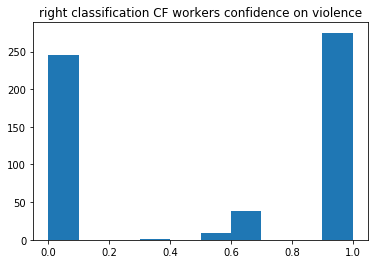

In [153]:
plt.hist(svm_results_CF_judgment_merged_righ_classification.violence_confidence)
plt.title('right classification CF workers confidence on violence')

In [155]:
svm_results_CF_judgment_merged_pos = svm_results_CF_judgment_merged_righ_classification[
    svm_results_CF_judgment_merged_righ_classification['violence'] == 1]

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


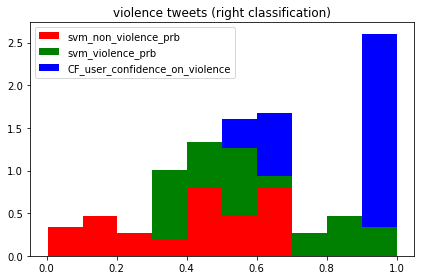

In [174]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_pos.non_vio_prob,
         svm_results_CF_judgment_merged_pos.vio_prob,
         svm_results_CF_judgment_merged_pos.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('violence tweets (right classification)')
plt.tight_layout()
plt.show()

In [175]:
svm_results_CF_judgment_merged_neg = svm_results_CF_judgment_merged_righ_classification[
    svm_results_CF_judgment_merged_righ_classification['violence'] == 0]

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


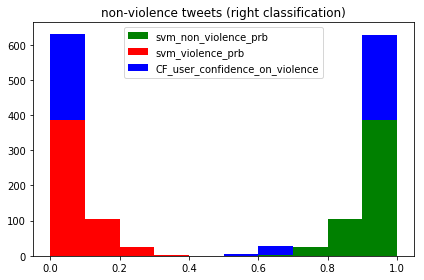

In [176]:
colors = ['green', 'red', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_neg.non_vio_prob,
         svm_results_CF_judgment_merged_neg.vio_prob,
         svm_results_CF_judgment_merged_neg.violence_confidence],stacked=True,normed=0,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('non-violence tweets (right classification)')
plt.tight_layout()
plt.show()

In [179]:
svm_results_CF_judgment_merged_mis_classification = svm_results_CF_judgment_merged[
                                                    svm_results_CF_judgment_merged['violence'] != svm_results_CF_judgment_merged['violence_prediction']
                                                    ]

In [182]:
svm_results_CF_judgment_merged_misclassififcation_pos = svm_results_CF_judgment_merged_mis_classification[
    svm_results_CF_judgment_merged_mis_classification['violence'] == 1]

In [183]:
svm_results_CF_judgment_merged_misclassififcation_neg = svm_results_CF_judgment_merged_mis_classification[
    svm_results_CF_judgment_merged_mis_classification['violence'] == 0]

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


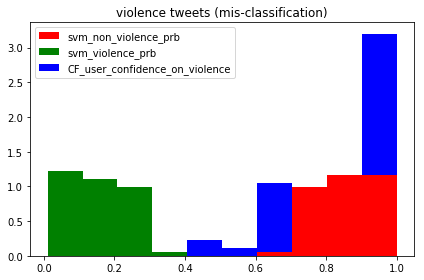

In [187]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_misclassififcation_pos.non_vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_pos.vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_pos.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('violence tweets (mis-classification)')
plt.tight_layout()
plt.show()

/Users/fatma/anaconda2/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


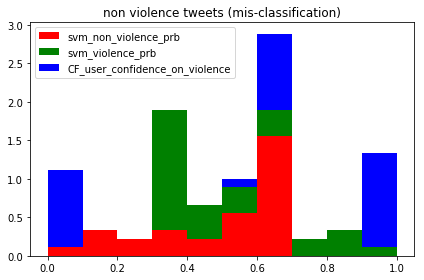

In [186]:
colors = ['red', 'green', 'blue']
labels = ['svm_non_violence_prb', 'svm_violence_prb', 'CF_user_confidence_on_violence']
plt.hist([svm_results_CF_judgment_merged_misclassififcation_neg.non_vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_neg.vio_prob,
         svm_results_CF_judgment_merged_misclassififcation_neg.violence_confidence],stacked=True,normed=1,
         histtype='bar',color=colors, label=labels )
plt.legend(prop={'size': 10})
plt.title('non violence tweets (mis-classification)')
plt.tight_layout()
plt.show()